In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# LOADING DATA

In [4]:
# Reading the data
data_0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/0.csv', header = None, encoding= 'unicode_escape')
data_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/1.csv', header = None, encoding= 'unicode_escape')
data_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/2.csv', header = None, encoding= 'unicode_escape')
data_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/3.csv', header = None, encoding= 'unicode_escape')

data = pd.concat([data_0, data_1, data_2, data_3], ignore_index=True)

display(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,4.0,13.0,-18.0,-30.0,-119.0,-45.0,17.0,6.0,-1.0,-9.0,27.0,20.0,91.0,71.0,-26.0,-1.0,0.0,1.0,13.0,20.0,-62.0,-19.0,29.0,2.0,2.0,0.0,-23.0,-1.0,-80.0,4.0,-7.0,-6.0,-12.0,-27.0,-11.0,-16.0,-67.0,-8.0,-27.0,1.0,1.0,13.0,-8.0,-11.0,21.0,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,0.0,7.0,-31.0,-33.0,-48.0,-52.0,34.0,10.0,5.0,-9.0,23.0,63.0,76.0,49.0,-27.0,-7.0,-7.0,-3.0,0.0,4.0,-111.0,-2.0,-7.0,7.0,11.0,11.0,2.0,2.0,76.0,3.0,7.0,-2.0,0.0,-6.0,21.0,-3.0,0.0,-8.0,-40.0,-4.0,-1.0,6.0,-2.0,-2.0,-105.0,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,4.0,16.0,24.0,9.0,33.0,34.0,-1.0,-4.0,-3.0,-6.0,-7.0,-11.0,-85.0,-12.0,-10.0,-2.0,-3.0,-2.0,-8.0,-30.0,-16.0,-22.0,-21.0,-7.0,-8.0,-12.0,-14.0,-18.0,-76.0,-44.0,27.0,7.0,4.0,-4.0,-10.0,23.0,127.0,69.0,-25.0,-12.0,-9.0,1.0,18.0,-33.0,-128.0,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,-3.0,-4.0,18.0,21.0,-9.0,2.0,-8.0,0.0,3.0,5.0,-14.0,-15.0,13.0,-13.0,11.0,-4.0,-5.0,-8.0,-30.0,-27.0,-128.0,-22.0,-3.0,-5.0,-8.0,0.0,25.0,-9.0,-28.0,2.0,-22.0,8.0,8.0,-2.0,2.0,12.0,53.0,20.0,28.0,-9.0,-5.0,-5.0,-7.0,-7.0,-54.0,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,4.0,13.0,13.0,-16.0,-45.0,-7.0,-84.0,-8.0,-3.0,-4.0,-36.0,-26.0,-128.0,-55.0,75.0,3.0,-8.0,-12.0,14.0,12.0,87.0,56.0,-3.0,2.0,0.0,-7.0,4.0,15.0,-13.0,0.0,-15.0,1.0,3.0,8.0,-2.0,-6.0,-55.0,-24.0,1.0,5.0,5.0,2.0,11.0,12.0,60.0,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11673,-3.0,-1.0,-1.0,-1.0,-28.0,20.0,5.0,0.0,-5.0,0.0,2.0,5.0,-10.0,-17.0,-3.0,-2.0,12.0,2.0,2.0,2.0,-4.0,-28.0,1.0,-6.0,-5.0,-1.0,1.0,0.0,11.0,9.0,-4.0,14.0,2.0,-2.0,-2.0,-8.0,-17.0,1.0,-2.0,6.0,-14.0,-3.0,-4.0,-2.0,27.0,18.0,-6.0,-17.0,-4.0,1.0,-2.0,1.0,13.0,-12.0,-3.0,-3.0,1.0,4.0,3.0,4.0,-51.0,-49.0,5.0,-9.0,3
11674,-13.0,-5.0,-4.0,-3.0,-4.0,-24.0,-10.0,-8.0,20.0,9.0,9.0,7.0,5.0,50.0,31.0,18.0,-3.0,-3.0,1.0,-2.0,17.0,-6.0,-10.0,-18.0,-11.0,-5.0,-2.0,-2.0,10.0,21.0,-2.0,15.0,5.0,-2.0,-2.0,-6.0,-6.0,-50.0,-16.0,7.0,-12.0,-2.0,-3.0,1.0,21.0,48.0,12.0,-12.0,-1.0,3.0,2.0,5.0,-12.0,-8.0,5.0,6.0,-3.0,-3.0,-3.0,-5.0,-4.0,-45.0,-12.0,-15.0,3
11675,-1.0,-3.0,-1.0,1.0,30.0,38.0,-1.0,36.0,-10.0,1.0,4.0,0.0,-3.0,33.0,-2.0,-1.0,-1.0,2.0,-3.0,0.0,-38.0,-25.0,0.0,3.0,2.0,-1.0,0.0,-3.0,14.0,0.0,-1.0,-3.0,-3.0,-4.0,-3.0,-6.0,-2.0,13.0,-5.0,-19.0,-6.0,-5.0,-4.0,1.0,41.0,-10.0,-4.0,-9.0,3.0,3.0,2.0,3.0,1.0,50.0,12.0,14.0,-8.0,-4.0,-4.0,-4.0,-21.0,-29.0,-5.0,0.0,3
11676,1.0,4.0,4.0,5.0,9.0,-10.0,4.0,1.0,-2.0,-1.0,-1.0,-1.0,-5.0,12.0,1.0,-19.0,0.0,-4.0,-4.0,0.0,25.0,0.0,3.0,-5.0,1.0,1.0,-2.0,-4.0,-31.0,-17.0,-7.0,5.0,3.0,-5.0,-3.0,-1.0,4.0,-48.0,-13.0,-5.0,-14.0,6.0,5.0,6.0,-3.0,79.0,15.0,-6.0,-3.0,-1.0,-3.0,-1.0,-1.0,27.0,-2.0,-16.0,-3.0,0.0,-3.0,-5.0,-36.0,-90.0,3.0,5.0,3


The variable to be predicted is categorical. This problem is a supervised learning problem and the target variable is column 64.

The relevant metrics are accuracy, area under ROC curve, F1-score, sensitivity, specificity. For this problem, I'll use accuracy and F1-score

All of the variables in the given dataset seem to be relevant at first glance

All of the above variables are usable

In [6]:
# Dividing the dataframe into features and labels
X, Y = data.drop(64, axis = 1), data[64] 

print(X.shape, Y.shape)

(11678, 64) (11678,)


In [7]:

print(X, Y)

         0    1    2    3     4     5   ...   58    59    60    61     62    63
0      26.0  4.0  5.0  8.0  -1.0 -13.0  ...  8.0   5.0   4.0  -7.0  -59.0  16.0
1     -47.0 -6.0 -5.0 -7.0  13.0  -1.0  ...  6.0   5.0  13.0  21.0  111.0  15.0
2     -19.0 -8.0 -8.0 -8.0 -21.0  -6.0  ...  1.0  -8.0   7.0  21.0  114.0  48.0
3       2.0  3.0  0.0  2.0   0.0  22.0  ...  7.0  11.0  33.0  39.0  119.0  43.0
4       6.0  0.0  0.0 -2.0 -14.0  10.0  ...  2.0   6.0 -13.0 -24.0 -112.0 -69.0
...     ...  ...  ...  ...   ...   ...  ...  ...   ...   ...   ...    ...   ...
11673  -3.0 -1.0 -1.0 -1.0 -28.0  20.0  ...  3.0   4.0 -51.0 -49.0    5.0  -9.0
11674 -13.0 -5.0 -4.0 -3.0  -4.0 -24.0  ... -3.0  -5.0  -4.0 -45.0  -12.0 -15.0
11675  -1.0 -3.0 -1.0  1.0  30.0  38.0  ... -4.0  -4.0 -21.0 -29.0   -5.0   0.0
11676   1.0  4.0  4.0  5.0   9.0 -10.0  ... -3.0  -5.0 -36.0 -90.0    3.0   5.0
11677  -2.0  4.0  2.0 -4.0  12.0   3.0  ... -1.0  -2.0 -30.0  64.0   11.0   5.0

[11678 rows x 64 columns] 0        0
1 

# TRANSFORMING THE DATA

In [8]:
# Segregating the numerical and categorical data types
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

# Converting the categorical variables into one-hot dummy variables and scaling the numerical variables
transforms = [('cat', OneHotEncoder(), categorical_ix), ('num', StandardScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=transforms)
X = col_transform.fit_transform(X)

In [9]:
# Sanity check of shapes
print(X.shape)
print(Y.shape)

(11678, 64)
(11678,)


# PCA ON DATASET
# SOLUTION OF Q5

In [10]:
# Testing all possible dimension reductions
n_components_list = [i for i in range(1, 65)]

# Tracking the RMSE values obtained
rmse_list = []

# Keeping the RMSE less than 1% of the std of the L2 norm of X
strict_criteria = []

# Achieving a minimum of 95% explained variance
relaxed_criteria = []

for n_components in n_components_list:

    # Carrying out dimensionality reduction
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_new = pca.transform(X)

    # Calculating the total explained variance
    var_ratio = pca.explained_variance_ratio_
    sum_var_ratio = sum(pca.explained_variance_ratio_)
    
    if sum_var_ratio > 0.95:
        relaxed_criteria.append(n_components)

    # Reconstructing the original data from the transformed data
    X_recon = pca.inverse_transform(X_new)

    # Calculating the RMSE value
    sq_error = np.square(X - X_recon)
    tot_sq_error = np.sum(sq_error)
    mse = tot_sq_error/float(X.size)
    rmse = math.sqrt(mse)
    rmse_list.append(rmse)

    # Calculating the std of the L2 norm of X
    X_sq = np.square(X)
    X_norms = np.sqrt(np.sum(X_sq, axis = 1))
    std_X_norm = np.std(X_norms)

    if rmse < 0.01*std_X_norm:
        strict_criteria.append(n_components)

print(strict_criteria)
print(relaxed_criteria)


[64]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


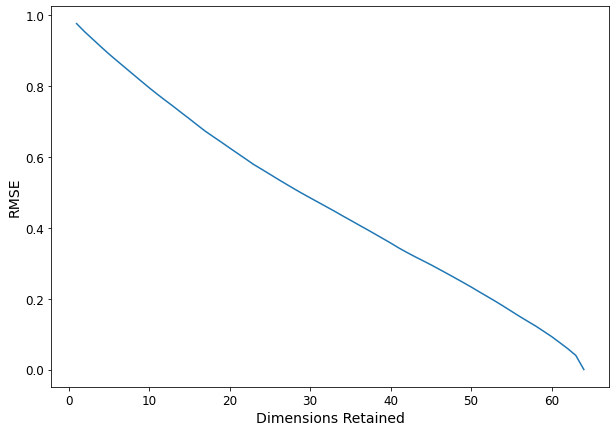

In [11]:
# Setting the figure size
plt.figure(figsize = (10, 7))

plt.plot(n_components_list, rmse_list)

# Setting various axis parameters
plt.tick_params(axis='x', which='major', labelsize=12)
plt.xlabel("Dimensions Retained", fontsize = 14)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.ylabel("RMSE", fontsize = 14)
plt.show()

From the above plot and obtained values, it's clear that the required criteria of the RMSE reconstruction error being less than 1% of the standard deviation of the L2 norm of the 64 variable input is only satisfied when n_components = 64, which is effectively the original data, which means that this criteria cannot be satisfied if we apply any sort of dimension reduction on X

For the purposes of simplifying the predictions in this question, I'm using the weaker criteria of the explained variance being greater than 95% which yeilds a minimum dimension reduction to 51 dimensions

In [12]:
# Carrying out dimension reduction to the minimum number of dimensions possible 
pca = PCA(n_components=relaxed_criteria[0])
pca.fit(X)
X_transformed = pca.transform(X)

# PREPROCESSING AND TRAINING SCHEMES

For this classification task, the ML frameworks I will be using for this are - SVM's, and Random Forest

I will not be explicitly using a validation set, and only divide the training set into a training and test set (in 85:15 ratio). I will be using 5-fold CV later with the algorithms to have a 70:15:15 split of the data

In [13]:
from sklearn.model_selection import train_test_split

# Splliting the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.15, shuffle = True)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9926, 51)
(9926,)
(1752, 51)
(1752,)


# SVC

In [14]:
# Setting up a parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ('linear', 'rbf')}

# Carrying out a grid search with 5-fold cross validation
gsc = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)

# Fitting the training data
grid_result_svc = gsc.fit(X_train, Y_train)

In [15]:
best_params_svc = grid_result_svc.best_params_

# Creating the best optimizer on the basis of performance on the CV set
best_svc = SVC(kernel=best_params_svc['kernel'], C=best_params_svc['C'])
best_svc.fit(X_train, Y_train)
Y_pred = best_svc.predict(X_test)

# F1 score
f1 = f1_score(Y_test, Y_pred, average='micro')

# ROC-AUC scoroc_auc = roc_auc_score(Y_test, Y_pred, average='micro', multi_class='ovo')re
accuracy = accuracy_score(Y_test, Y_pred)

print("F1 score :", f1, "| Accuracy :", accuracy)

F1 score : 0.920662100456621 | Accuracy : 0.920662100456621


# RANDOM FOREST

In [16]:
# Setting up a parameter grid
param_grid = {'n_estimators': [10, 50, 100, 500, 1000]}

# Carrying out a grid search with 5-fold cross validation
gsc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

# Fitting the training data
grid_result = gsc.fit(X_train, Y_train)

In [17]:
best_params = grid_result.best_params_

# Creating the best optimizer on the basis of performance on the CV set
best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'])
best_rf.fit(X_train, Y_train)
Y_pred = best_rf.predict(X_test)

# F1 score
f1 = f1_score(Y_test, Y_pred, average='micro')

# ROC-AUC scoroc_auc = roc_auc_score(Y_test, Y_pred, average='micro', multi_class='ovo')re
accuracy = accuracy_score(Y_test, Y_pred)

print("F1 score :", f1, "| Accuracy :", accuracy)

F1 score : 0.8025114155251142 | Accuracy : 0.8025114155251142
